<a href="https://colab.research.google.com/github/jtfreitas/NN_DL/blob/main/HW2/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q optuna

In [4]:
import shutil
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
shutil.copy2('/content/drive/MyDrive/vae_tools.py', '/content/vae_tools.py')

Mounted at /content/drive


'/content/vae_tools.py'

In [3]:
%load_ext autoreload
%autoreload 2
import random
from tqdm import tqdm
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision import utils as vutils
import optuna

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation


import vae_tools as vt
seed = 69420
# Check if GPU is available
device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"Device in use: {device}")

random.seed(seed)
torch.manual_seed(seed)
print(f"Random seed: {seed}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device in use: cuda
Random seed: 69420


In [4]:
data_dir = 'dataset'

train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

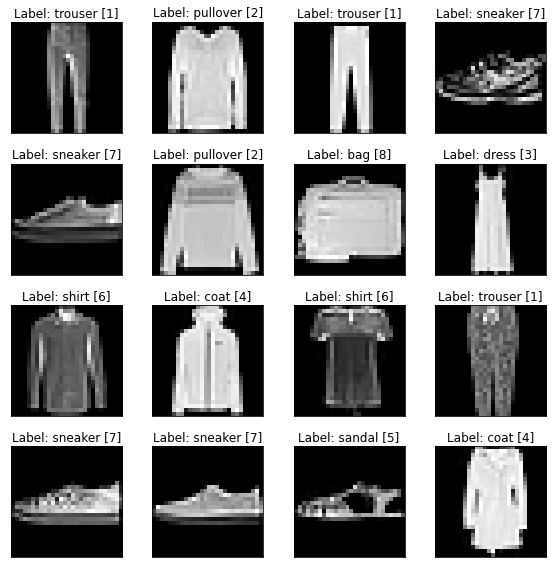

In [5]:
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
fig, axs = plt.subplots(4, 4, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title(f'Label: {label_names[label]} [{label}]')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [6]:
# In this case the train_transform and test_transform are the same, 
# but we keep them separate for potential future updates
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

### Define dataloaders
train_dataloader = DataLoader(train_dataset,
                            batch_size=256, shuffle=True, num_workers=2)
test_dataloader  = DataLoader(test_dataset,
                            batch_size=256, shuffle=False)

# Set the train and test transform
train_dataset.transform = train_transform
test_dataset.transform = test_transform

batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


In [22]:
### Initialize the autoencoder
params = {
    'latent_space' : 5,
    'conv1' : {'filters' : 16, 'kernel': 3, 'stride' : 2, 'padding' : 1},
    'conv2' : {'filters' : 32, 'kernel': 3, 'stride' : 2, 'padding' : 1},
    'conv3' : {'filters' : 64, 'kernel': 3, 'stride' : 2, 'padding' : 0},
    'lin1' : 64
    }
autoencoder = vt.Autoencoder(28, params, device)

### Define the loss function, optimizer, learning rate
loss_fn = torch.nn.MSELoss()
params_to_optimize = [
    {'params': autoencoder.parameters()},
]
lr = 5e-4 # Learning rate
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

# Move both the autoencoder to the selected device
autoencoder.to(device)
loss_fn.to(device)

MSELoss()

In [23]:
no_epochs = 10

loss = vt.train_AE(autoencoder,  train_dataloader, test_dataloader,
                        no_epochs, loss_fn, optim, device, save_dir=f'VAE_z{params["latent_space"]}')


EPOCH 1/10 : 
partial train loss (single batch): 0.038898partial train loss (single batch): 0.038898	Finding validation loss... Validation loss: 0.036092
EPOCH 2/10 : 
partial train loss (single batch): 0.028040partial train loss (single batch): 0.028040	Finding validation loss... Validation loss: 0.026925
EPOCH 3/10 : 
partial train loss (single batch): 0.023717partial train loss (single batch): 0.023717	Finding validation loss... Validation loss: 0.024799
EPOCH 4/10 : 
partial train loss (single batch): 0.023224partial train loss (single batch): 0.023224	Finding validation loss... Validation loss: 0.023643
EPOCH 5/10 : 
partial train loss (single batch): 0.020205partial train loss (single batch): 0.020205	Finding validation loss... Validation loss: 0.023144
EPOCH 6/10 : 
partial train loss (single batch): 0.022593partial train loss (single batch): 0.022593	Finding validation loss... Validation loss: 0.022650
EPOCH 7/10 : 
partial train loss (single batch): 0.023434partial train loss 

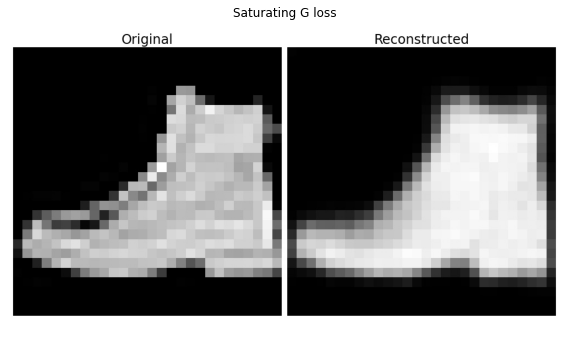

In [27]:
import matplotlib.image as mpimg
fig = plt.figure(figsize=(8,6), tight_layout='pad')
plt.title('Saturating G loss')
plt.axis("off")

img_list = [mpimg.imread(f'VAE_z{params["latent_space"]}/plots/t={i}.jpg') for i in range(1, no_epochs+1)]
ims = [[plt.imshow(i, animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

In [ ]:
def objective(trial):

    params = {
        'conv1': {'filters': trial.suggest_int('filters1', 16, 32),
                  'kernel': 3,
                  'stride': 2,
                  'padding': 1},
        'conv2': {'filters': trial.suggest_int('filters2', 64, 128),
                  'kernel': 3,
                  'stride': 2,
                  'padding': 1},
        'conv3': {'filters': trial.suggest_int('filters3', 256, 512),
                  'kernel': 3,
                  'stride': 2,
                  'padding': 0},
        'lin1': trial.suggest_int('lin1', 32, 128),
        'latent_space': trial.suggest_int('latent_space', 2, 16)
    }

    model = vt.Autoencoder(28, params, device, keep_loss=False)
    model.to(device)

    lr = trial.suggest_loguniform('lr', 1e-5, 5e-4)
    params_to_optimize = [
        {'params': model.parameters()},
    ]
    optim_type = trial.suggest_categorical('optimizer', ['Adam', 'Adagrad', 'RMSprop'])
    optim = getattr(torch.optim, optim_type)(params_to_optimize, lr=lr)
    loss_fn = torch.nn.MSELoss()
    val_loss = vt.train_VAE(model, train_dataloader, test_dataloader, 5, loss_fn, optim, device, verbose=False)[0]
    return val_loss


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials = 20)

In [ ]:
best_params = study.best_params

best_params = {
    'conv1': {'filters': study.best_params['filters1'],
                'kernel': 3,
                'stride': 2,
                'padding': 1},
    'conv2': {'filters': study.best_params['filters2'],
                'kernel': 3,
                'stride': 2,
                'padding': 1},
    'conv3': {'filters': study.best_params['filters3'],
                'kernel': 3,
                'stride': 2,
                'padding': 0},
    'lin1': study.best_params['lin1'],
    'latent_space': study.best_params['latent_space']
}

best_VAE = vt.Autoencoder(28, best_params, device)

loss_fn = torch.nn.MSELoss()
params_to_optimize = [
    {'params': best_VAE.parameters()},
]
optim = torch.optim.Adam(params_to_optimize, lr=study.best_params['lr'], weight_decay=1e-5)

best_VAE.to(device)
loss_fn.to(device)

In [ ]:
vt.train_VAE(best_VAE, train_dataloader, test_dataloader, 20, loss_fn, optim = optim, device = device, save_dir =f'best_VAE_z{best_VAE.latent_space}')

In [ ]:
fig, axs = plot_inout(best_VAE, test_dataset)
fig.suptitle('Autoencoder I/O', fontsize=28)

# GAN

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
n_classes = len(train_dataset.targets.unique())
params = {'latent_space' : 100, 'G_filters' : 64, 'D_filters' : 28, 'n_channels' : 1, 'opt' : 'Adam', 'lr' : 1e-5}

#gan = vt.GAN(params, device)

In [ ]:




criterion = nn.BCEWithLogitsLoss()

gan.to(device)
loss_historhy, img_list = vt.train_GAN(gan, train_dataloader, 10, criterion, device, saturating=True, snapshots = True)

In [ ]:
test_data.shape

In [ ]:
gan.zero_grad()
test_data = test_dataset[0][0].unsqueeze(0).to(device)
D_out = gan.netD(test_data)

label = torch.tensor([1],
                dtype=torch.float, device=device).reshape((1,1,1,1))
    

criterion(D_out, label)

In [ ]:
rand_noise = torch.randn(64, gan.latent_space, 1, 1, device=device)

gen_fakes = gan.netG(rand_noise).cpu().detach().numpy()[0]


In [ ]:
plt.imshow(gen_fakes[0], cmap= 'gist_gray')

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.title('Saturating G loss')
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), cmap='gist_gray', animated=True)] for i in gen_fakes]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

In [ ]:
class Generator(nn.Module):
    def __init__(self, params):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(params['latent_space'], params['G_filters'] * 4, 3, 2, 0, bias=False),
            nn.BatchNorm2d(params['G_filters'] * 4),
            nn.ReLU(True),
            # state size. (G_filters*8, 4, 4)
            nn.ConvTranspose2d(params['G_filters'] * 4, params['G_filters'] * 2, 3, 2, 0, bias=False),
            nn.BatchNorm2d(params['G_filters'] * 2),
            nn.ReLU(True),
            # state size. (G_filters*4, 8, 8)
            nn.ConvTranspose2d( params['G_filters'] * 2, params['G_filters'], 3, 2, 0, bias=False),
            nn.BatchNorm2d(params['G_filters']),
            nn.ReLU(True),
            # state size. (G_filters*2, 16, 16)
            nn.ConvTranspose2d( params['G_filters'], params['n_channels'], 3, 2, 2, 1, bias=False),
            nn.Tanh()
            # state size. (n_channels, 64, 64)
        )

    def forward(self, input):
        return self.main(input)

# Create the generator
netG = Generator(params).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
#netG.apply(weights_init)

# Print the model
print(netG)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, params, conditional=False):
        super(Discriminator, self).__init__()
        self.conditional=conditional
        self.main = nn.Sequential(
            # input is (1,28,28)
            nn.Conv2d(in_channels=params['n_channels'], out_channels=params['D_filters'],
                      kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (D_filters, 14, 14)
            nn.Conv2d(in_channels=params['D_filters'], out_channels=params['D_filters'] * 2,
                      kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(params['D_filters'] * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (D_filters*2, 7, 7)
            nn.Conv2d(in_channels=params['D_filters'] * 2, out_channels=params['D_filters'] * 4,
                      kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(params['D_filters'] * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (D_filters*4, 3, 3)
            nn.Conv2d(in_channels = params['D_filters']* 4, out_channels=1,
                      kernel_size = 4, stride=2, padding=1)
            # scalar output (1, 1, 1)
        )

    def forward(self, input):
        if self.conditional:
            pass

        else:
            return self.main(input)

In [ ]:
class GAN(nn.Module):
    def __init__(self, params, device, conditional=False):
        super(GAN, self).__init__()
        self.conditional = conditional
        self.latent_space = params['latent_space']
        self.netG = Generator(params)
        self.netD = Discriminator(params, conditional = self.conditional)
        self.epochs_trained = 0
        self.device = device
        
        self.optimizerD = getattr(torch.optim, params['opt'])(self.netD.params_to_optimize(), lr=params['lr'])
        self.optimizerG = getattr(torch.optim, params['opt'])(self.netG.params_to_optimize(), lr=params['lr'])


In [ ]:
# Create the Discriminator
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
netD = Discriminator(params).to(device)
img = img.to(device)
dsc_img = netD(img).detach().cpu().numpy()
img.detach()
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
# netD.apply(weights_init)

# Print the model
print(netD)
plt.imshow(dsc_img[0][0], cmap='gist_gray')

dsc_img.shape

In [ ]:
# Initialize BCELoss function
criterion = nn.BCEWithLogitsLoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, params['latent_space'], 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D

beta1 = 0.5
optimizerD = torch.optim.Adam(netD.parameters(), lr=params['lr'], betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=params['lr'], betas=(beta1, 0.999))

In [ ]:
getattr(torch.optim, "Adam")

In [ ]:
# Training Loop
# Lists to keep track of progress

num_epochs = 10
img_list = []
G_losses = []
D_losses = []
iters = 0
latent_space = params['latent_space']
saturating = False

print("Starting Training Loop...")
# For each epoch
for epoch in range(1, num_epochs+1):
    # For each batch in the dataloader
    for i, data in enumerate(train_dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label,
                           dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_space, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        if saturating:
            # Saturating loss: Use fake_label y = 0 to get J(G) = log(1−D(G(z)))
            label.fill_(fake_label)
        else:
            # Non-saturating loss: fake labels are real for generator cost
            label.fill_(real_label)

        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output

        if saturating:
            errG = -criterion(output, label)  # Saturating loss: -J(D) = J(G)
        else:
            errG = criterion(output, label)  # Non-saturating loss
        
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise

        if (iters % 500 == 0) or ((epoch == num_epochs) and (i == len(train_dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

        print(f'[{epoch}/{num_epochs}]\tLoss_D: {errD.item():.4f}, \tLoss_G: {errG.item():.4f}, \tD(x): {D_x:.4f} \tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}', end = '\r')
    print(f'[{epoch}/{num_epochs}]\tLoss_D: {errD.item():.4f}, \tLoss_G: {errG.item():.4f}, \tD(x): {D_x:.4f} \tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}', end = '\n')

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and discriminator loss")
plt.plot(G_losses,label="Non-saturating G loss", alpha=0.75)
plt.plot(D_losses,label="Non-saturating D loss", alpha=0.75)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Visualize results with saturating G loss
fig = plt.figure(figsize=(8,8))
plt.title('Saturating G loss')
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.axis("off")
plt.title("Real images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,3,2)
plt.axis("off")
plt.title("Fake images - saturating G loss")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))

In [ ]:
# Training Loop
saturating = False
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_space, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################


        if saturating:
            label.fill_(fake_label) # Saturating loss: Use fake_label y = 0 to get J(G) = log(1−D(G(z)))
        else:
            label.fill_(real_label) # Non-saturating loss: fake labels are real for generator cost
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        
        if saturating:
            errG = -criterion(output, label) # Saturating loss: -J(D) = J(G)
        else:
            errG = criterion(output, label) # Non-saturating loss

        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)